In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Read in the files
chl_a = pd.read_csv('monthly_Chlorophyll_a_averages.csv')
ndci = pd.read_csv('monthly_ndci_averages.csv')
ssc = pd.read_csv('monthly_SSC_averages.csv')
tbd = pd.read_csv('monthly_turbidity_averages.csv')

In [3]:
# Subset the datasets for the month and mean columns
chl_a_subset = chl_a[['month', 'mean']].rename(columns={'mean': 'chl_a'})
ndci_subset = ndci[['month', 'mean']].rename(columns={'mean': 'ndci'})
ssc_subset = ssc[['month', 'mean']].rename(columns={'mean': 'ssc'})
tbd_subset = tbd[['month', 'mean']].rename(columns={'mean': 'tbd'})

In [4]:
# Merge the dataframes on the 'month' column
merged_df = chl_a_subset.merge(ndci_subset, on='month') \
                        .merge(ssc_subset, on='month') \
                        .merge(tbd_subset, on='month')

merged_df

,month,chl_a,ndci,ssc,tbd
0,2002-08,322.488621,-0.294500,4154.567990,170.248127
1,2002-09,680.343490,-0.199998,5671.488119,227.398316
2,2002-10,431.833269,-0.165717,8359.137935,323.912052
3,2002-11,146.449476,-0.274810,7544.772391,289.461416
4,2002-12,669.796149,-0.180434,8231.523425,316.852569
...,...,...,...,...,...
263,2024-07,2021.627986,-0.274382,12930.867034,478.771965
264,2024-08,1044.550636,-0.309919,7546.054987,292.684297
265,2024-09,352.918585,-0.215742,9226.184187,357.963774
266,2024-10,133.381975,-0.181523,13540.679478,507.434586


In [5]:
#export as csv
merged_df.to_csv('water_quality_data.csv', index=False)

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   268 non-null    object 
 1   chl_a   268 non-null    float64
 2   ndci    268 non-null    float64
 3   ssc     268 non-null    float64
 4   tbd     268 non-null    float64
dtypes: float64(4), object(1)
memory usage: 10.6+ KB


In [7]:
# Convert the 'month' column to a datetime object
merged_df['month'] = pd.to_datetime(merged_df['month'])

In [8]:
#Set the month column as the index
merged_df.set_index('month', inplace=True)

In [9]:
#set the frequency of the data to monthly
merged_df.index.freq = 'MS'

In [10]:
#Getting an overview of the descriptive statistics of the data
merged_df.describe()

,chl_a,ndci,ssc,tbd
count,2.680000e+02,268.000000,268.000000,268.000000
mean,2.129203e+04,-0.258701,7964.682056,310.503816
std,3.022053e+05,0.059360,3122.939876,108.309206
min,1.133977e+00,-0.468058,1718.615168,80.901697
25%,9.839088e+01,-0.298346,5785.306186,233.246609
50%,2.025182e+02,-0.253675,7537.472121,292.774184
75%,3.540929e+02,-0.214954,9708.164557,372.841065
max,4.896472e+06,-0.129695,21904.423224,778.085574


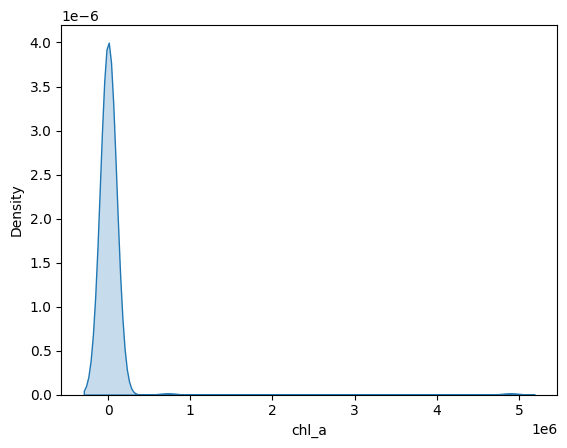

In [11]:
# Distribution of chl-a using kde plot
sns.kdeplot(merged_df['chl_a'], fill=True)
plt.show()

Because the chlorophyll-a data is heavily skewed, it would benefit from a transformation. Going for a log transform.

In [12]:
# Apply logarithmic transformation
merged_df['log_chl_a'] = np.log(merged_df['chl_a'])

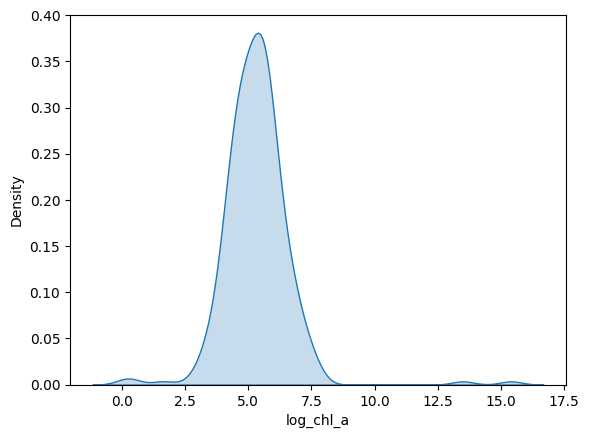

In [13]:
# Replot the transformed chl-a
sns.kdeplot(merged_df['log_chl_a'], fill=True)
plt.show()

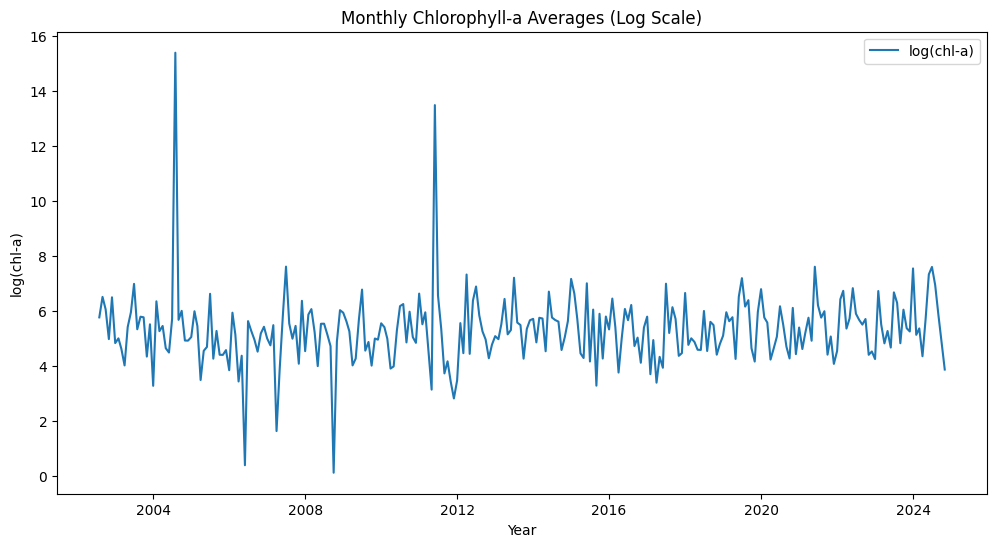

In [14]:
# Chlorophyll-a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df['log_chl_a'], label='log(chl-a)')
plt.title('Monthly Chlorophyll-a Averages (Log Scale)')
plt.xlabel('Year')
plt.ylabel('log(chl-a)')
plt.show()

At a glance, we observe significant spikes and dips in Chlorophyll-a data between 2004 and 2012.
Let us take a closer look into these observations by subsetting for this period's data.

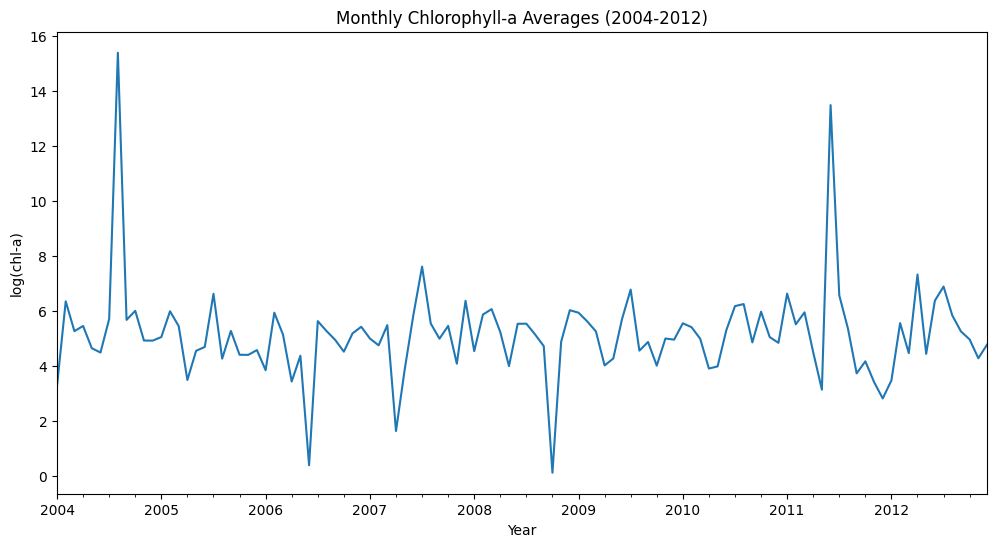

In [15]:
#subset for 2004 up to 2012 chl-a data
chl_a_04_12 = merged_df['log_chl_a'].loc['2004':'2012']
chl_a_04_12.plot(figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('log(chl-a)')
plt.title('Monthly Chlorophyll-a Averages (2004-2012)')
plt.show()

In [16]:
#Get the dates of the two largest values of chl-a
largest_chla_dates = chl_a_04_12.nlargest(2).index

# Unlog the data
largest_chla_values = np.exp(chl_a_04_12.nlargest(2))

largest_chla_dates, largest_chla_values

(DatetimeIndex(['2004-08-01', '2011-06-01'], dtype='datetime64[ns]', name='month', freq='82MS'),
 month
 2004-08-01    4.896472e+06
 2011-06-01    7.284185e+05
 Freq: 82MS, Name: log_chl_a, dtype: float64)

In [17]:
#Get the dates of the three smallest values of chl-a
smallest_chla_dates = chl_a_04_12.nsmallest(3).index

# Unlog the data
smallest_chla_values = np.exp(chl_a_04_12.nsmallest(3))

smallest_chla_dates, smallest_chla_values

(DatetimeIndex(['2008-10-01', '2006-06-01', '2007-04-01'], dtype='datetime64[ns]', name='month', freq=None),
 month
 2008-10-01    1.133977
 2006-06-01    1.488729
 2007-04-01    5.159579
 Name: log_chl_a, dtype: float64)

- After taking a closer look, it is noted that these spikes occurred in August 2004 and June 2011 whereas the heavy dips occured in October 2008, June 2006 and April 2007. Otherwise, the observations have been relatively stable.

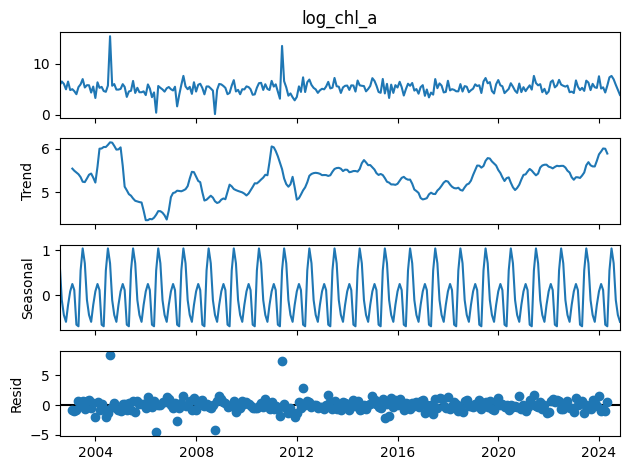

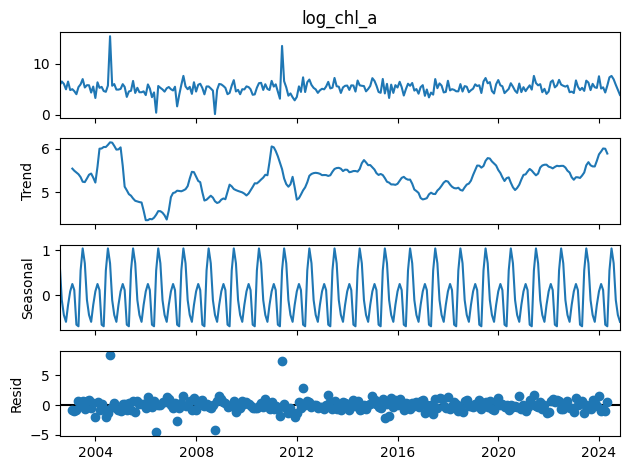

In [18]:
#decompose the log transformed chl-a
log_chla_decomposition = seasonal_decompose(merged_df['log_chl_a'], model='additive')
log_chla_decomposition.plot()

- After decomposing the time series, a light upward trend is observed as of the year 2020.

<Axes: xlabel='month'>

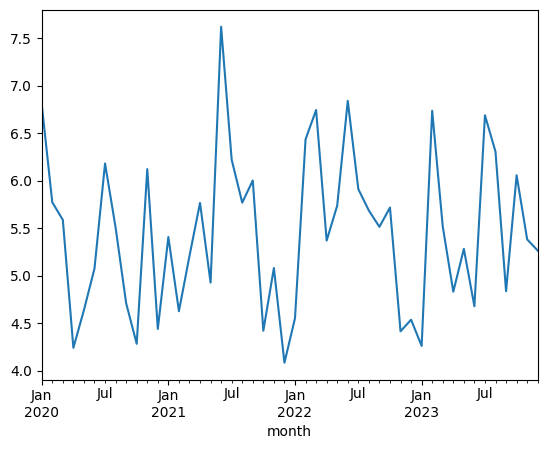

In [19]:
#Zooming into the chl-a seasonal component
latest_three_years_chla = merged_df['log_chl_a'].loc['2020':'2023']
latest_three_years_chla.plot()

- On further subsetting the values for the last four years, we observed repeated peaking of chlorophyll-a values around July.

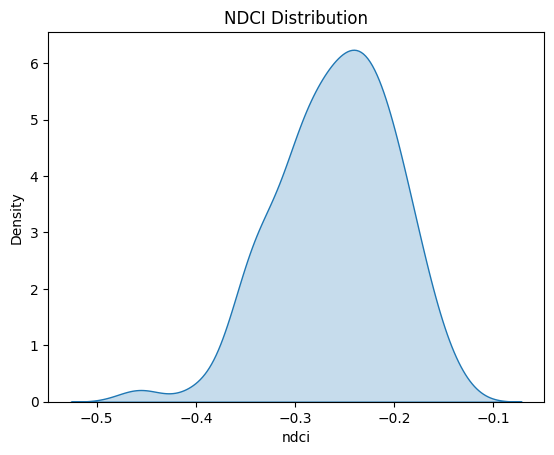

In [20]:
#Distribution of NDCI using kde plot
sns.kdeplot(merged_df['ndci'], fill=True)
plt.title('NDCI Distribution')
plt.show()

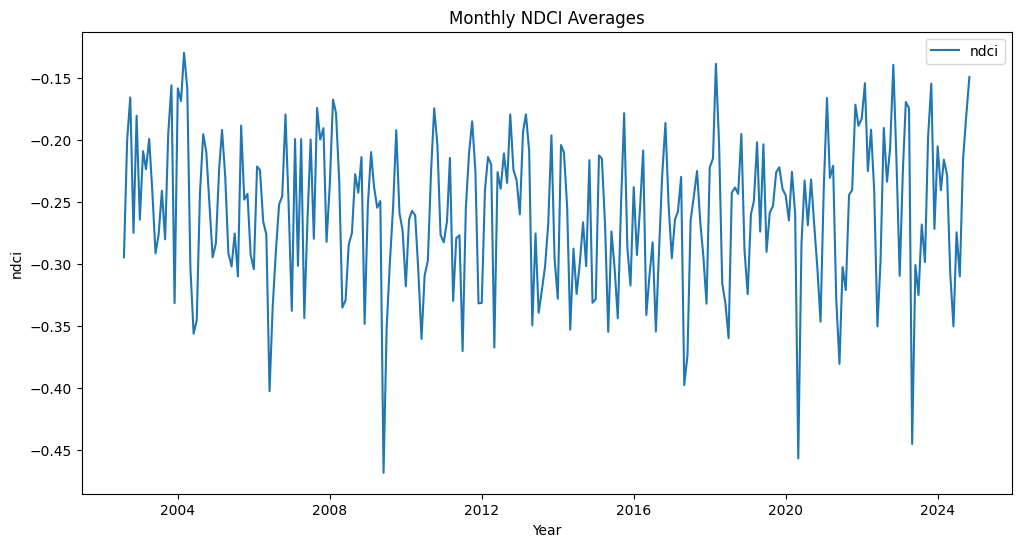

In [21]:
#NDCI plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df['ndci'], label='ndci')
plt.title('Monthly NDCI Averages')
plt.xlabel('Year')
plt.ylabel('ndci')
plt.show()

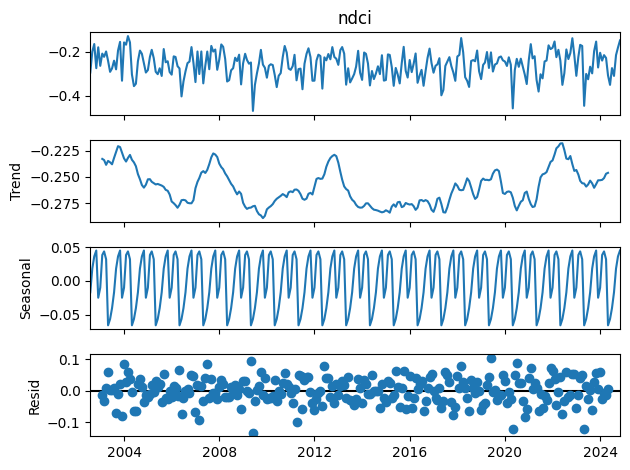

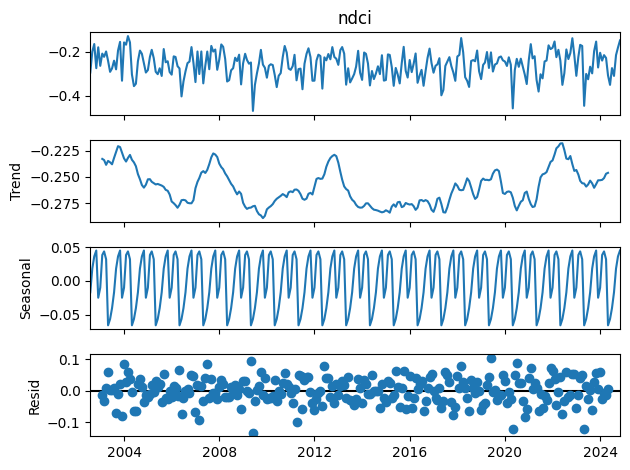

In [22]:
#decompose the time series into trend, seasonal and residual components
ndci_decomposition = seasonal_decompose(merged_df['ndci'], model='additive')
ndci_decomposition.plot()

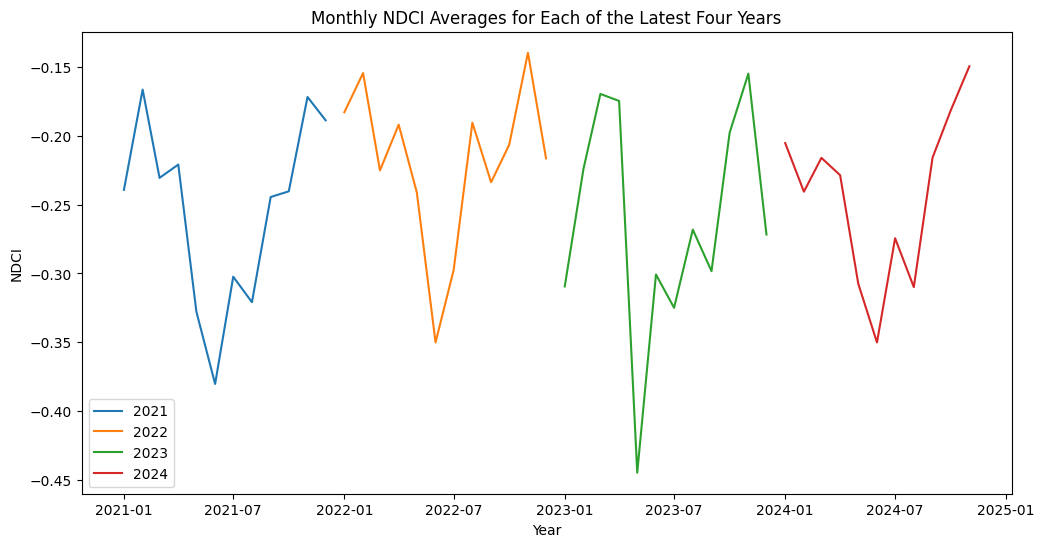

In [23]:
# Subset the data for the latest four years
latest_three_years_ndci = merged_df['ndci'].loc['2021':'2024']

# Plot a line plot for each of the three years
plt.figure(figsize=(12, 6))
sns.lineplot(data=latest_three_years_ndci.loc['2021'], label='2021')
sns.lineplot(data=latest_three_years_ndci.loc['2022'], label='2022')
sns.lineplot(data=latest_three_years_ndci.loc['2023'], label='2023')
sns.lineplot(data=latest_three_years_ndci.loc['2024'], label='2024')
plt.title('Monthly NDCI Averages for Each of the Latest Four Years')
plt.xlabel('Year')
plt.ylabel('NDCI')
plt.legend()
plt.show()

In [24]:
# Perform the ADF test for stationarity
result = adfuller(merged_df['ndci'])

# Extract and display the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if result[1] < 0.05:
    print("Reject the null hypothesis - the time series is stationary.")
else:
    print("Fail to reject the null hypothesis - the time series is non-stationary.")

ADF Statistic: -3.0985296669501716
p-value: 0.026662191234237177
Critical Values:
   1%: -3.4561550092339512
   5%: -2.8728972266578676
   10%: -2.5728222369384763
Reject the null hypothesis - the time series is stationary.


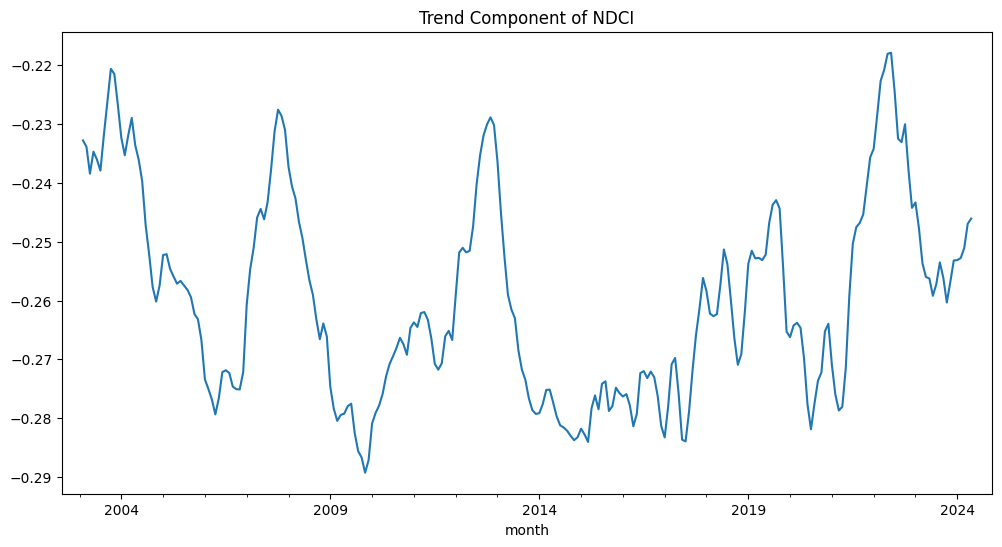

In [25]:
#Perform decomposition
ndci_decomposition = seasonal_decompose(merged_df["ndci"])

#Plot the trend component
ndci_decomposition.trend.plot(figsize=(12, 6))
plt.title('Trend Component of NDCI')
plt.show()

No meaningful trend of NDCI values is observed

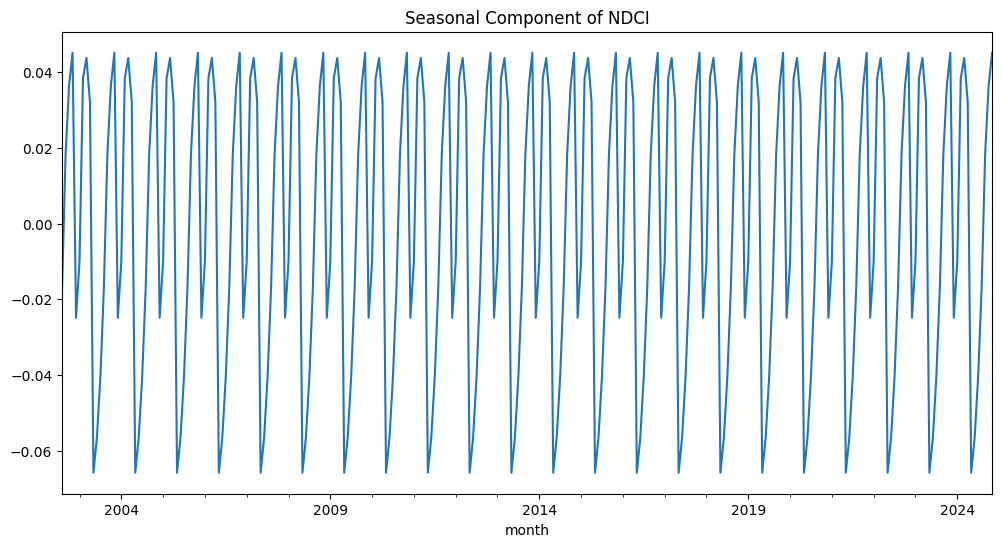

In [26]:
#Plot the seasonal component
ndci_decomposition.seasonal.plot(figsize=(12, 6))
plt.title('Seasonal Component of NDCI')
plt.show()

Zooming into a subseries of the data with 2 years.

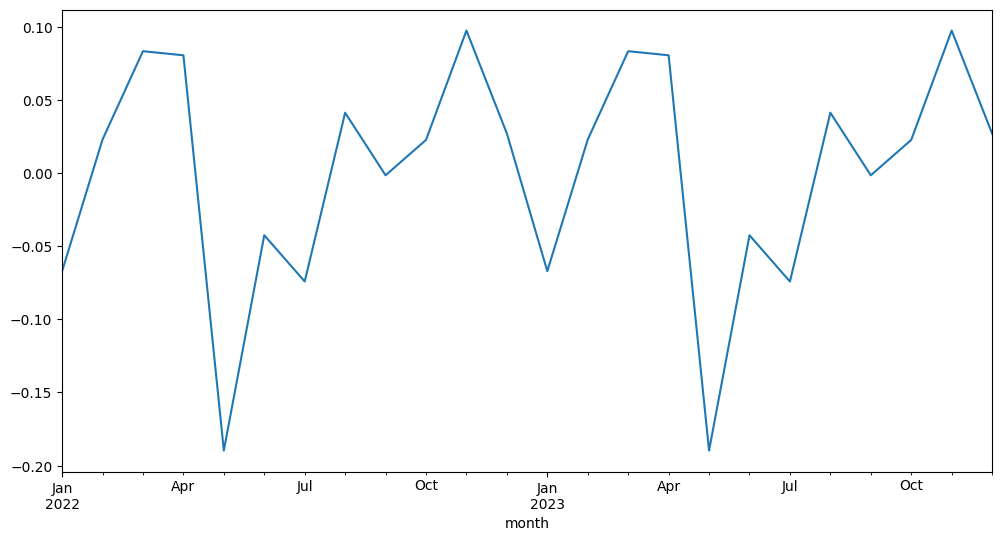

In [27]:
#subset for ndci values of  2022 and 2023
ndci_22_23 = merged_df['ndci'].loc['2022':'2023']

#decompose and plot the seasonal component
ndci_22_23_decomposition = seasonal_decompose(ndci_22_23, model='additive')
ndci_22_23_decomposition.seasonal.plot(figsize=(12, 6))
plt.show()

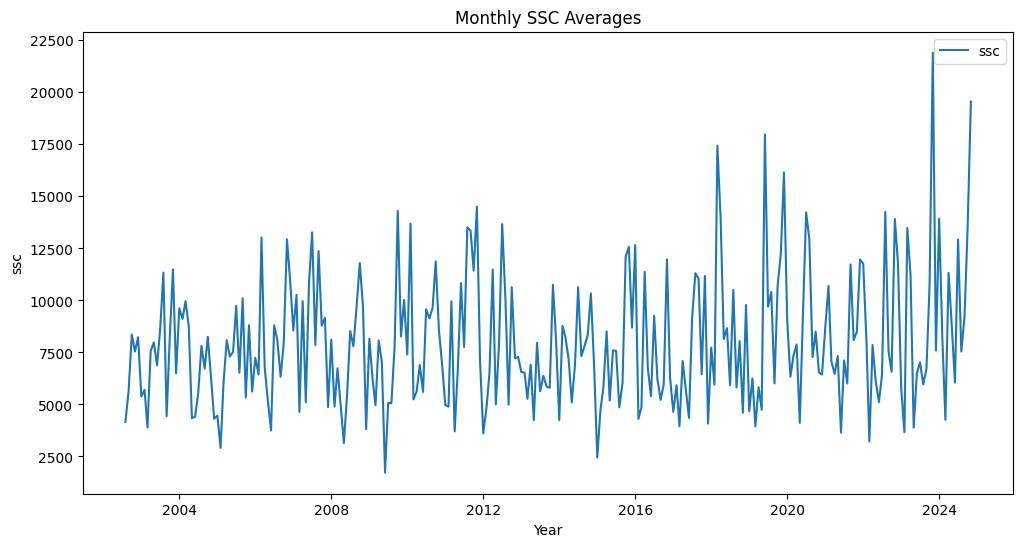

In [28]:
#SSC plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df['ssc'], label='ssc')
plt.title('Monthly SSC Averages')
plt.xlabel('Year')
plt.ylabel('ssc')
plt.show()

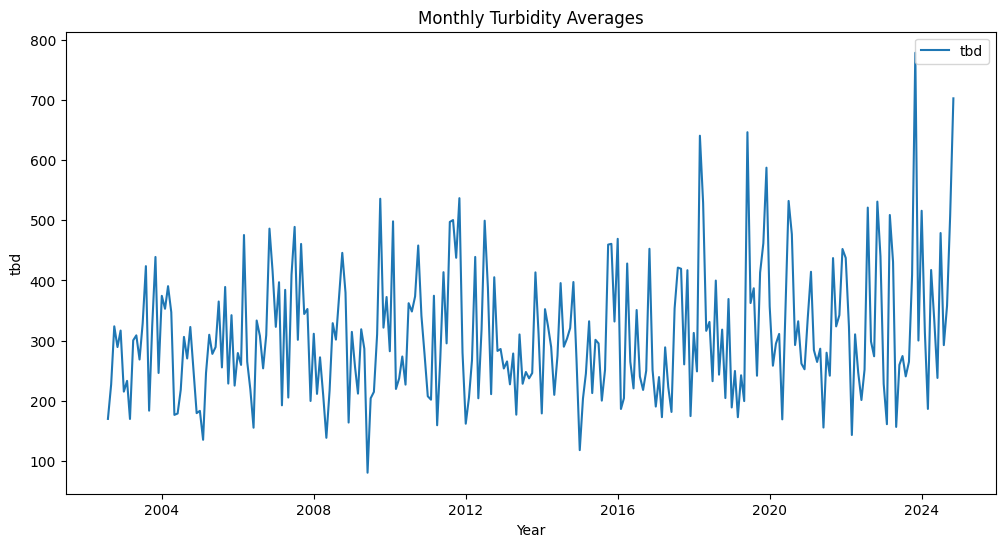

In [29]:
#turbidity plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df['tbd'], label='tbd')
plt.title('Monthly Turbidity Averages')
plt.xlabel('Year')
plt.ylabel('tbd')
plt.show()

In [30]:
#Compute the pct_change for ssc and tbd
merged_df['ssc_pct_change'] = merged_df['ssc'].pct_change()
merged_df['tbd_pct_change'] = merged_df['tbd'].pct_change()
merged_df.head()

,chl_a,ndci,ssc,tbd,log_chl_a,ssc_pct_change,tbd_pct_change
month,,,,,,,
2002-08-01,322.488621,-0.294500,4154.567990,170.248127,5.776068,NaN,NaN
2002-09-01,680.343490,-0.199998,5671.488119,227.398316,6.522598,0.365121,0.335688
2002-10-01,431.833269,-0.165717,8359.137935,323.912052,6.068040,0.473888,0.424426
2002-11-01,146.449476,-0.274810,7544.772391,289.461416,4.986680,-0.097422,-0.106358
2002-12-01,669.796149,-0.180434,8231.523425,316.852569,6.506973,0.091023,0.094628


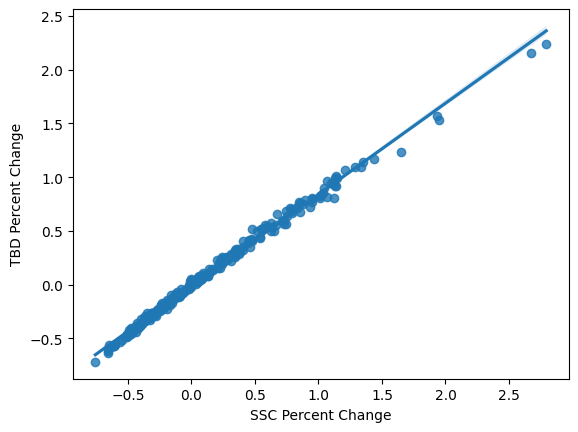

In [31]:
#Scatter plot of the two pct_changes
sns.regplot(data=merged_df, x='ssc_pct_change', y='tbd_pct_change')
plt.xlabel('SSC Percent Change')
plt.ylabel('TBD Percent Change')
plt.show()

In [32]:
# Compute the correlation between the two pct_changes
correlation = merged_df['ssc_pct_change'].corr(merged_df['tbd_pct_change'], method='pearson')
print(correlation)

0.9972386472129586


No surprise here, haha. Since because both metrics relate to the presence of particles suspended in a water body.

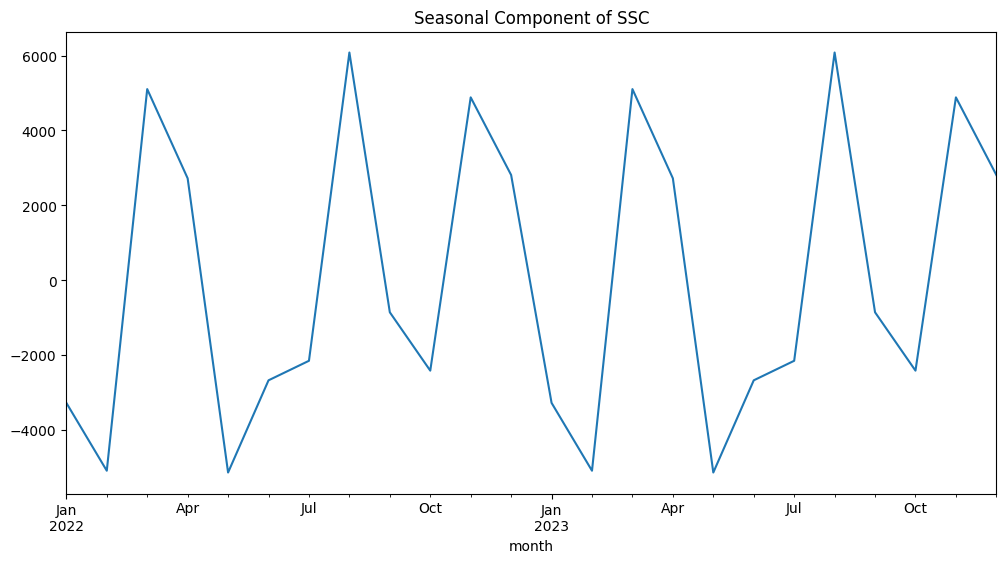

In [33]:
#Perform seasonal decomposition
decomposition = seasonal_decompose(merged_df["ssc"].loc["2022": "2023"])

#Plot the seasonal component
decomposition.seasonal.plot(figsize=(12, 6))
plt.title('Seasonal Component of SSC')
plt.show()

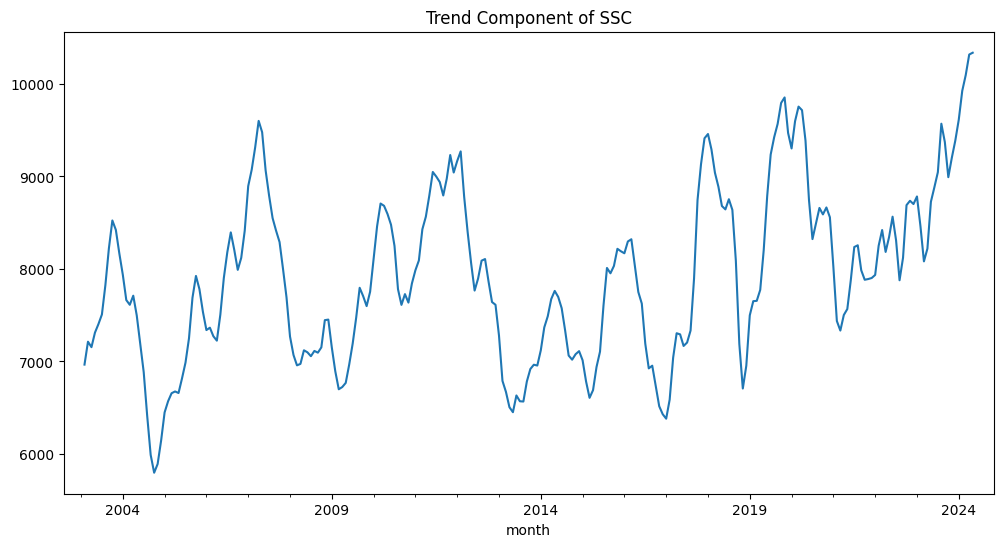

In [34]:
#Plot the seasonal component
decomposition_2 = seasonal_decompose(merged_df["ssc"])
decomposition_2.trend.plot(figsize=(12, 6))
plt.title('Trend Component of SSC')
plt.show()